## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [1]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

img = io.imread('histo_1.jpg')
print(np.max(img))


255


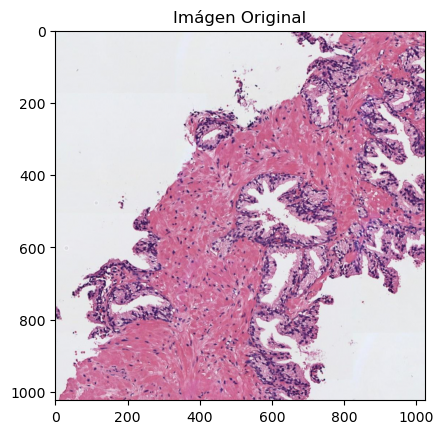

In [2]:
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
img_normalizada = img / 255.0 
# Visualizar la imagen
plt.imshow(img_normalizada, cmap='gray')
plt.title('Imágen Original')
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [4]:
import cv2

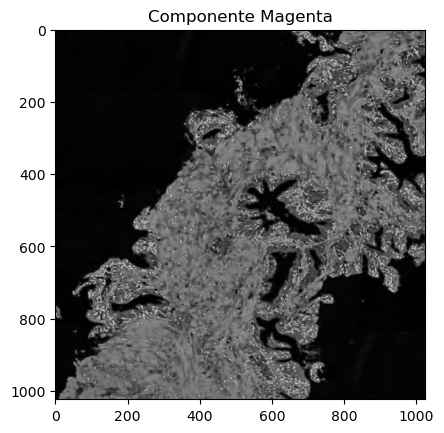

In [5]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)

with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(img_normalizada, axis=2)
    C = (1 - img_normalizada[..., 0] - K) / (1 - K)
    M = (1 - img_normalizada[..., 1] - K) / (1 - K)
    Y = (1 - img_normalizada[..., 2] - K) / (1 - K) 

CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
C,M,Y,K = cv2.split(CMYK)
# Visualizar la imagen del canal magenta
plt.imshow(M.astype('uint8'), cmap='gray')
plt.title('Componente Magenta')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

[0 1]


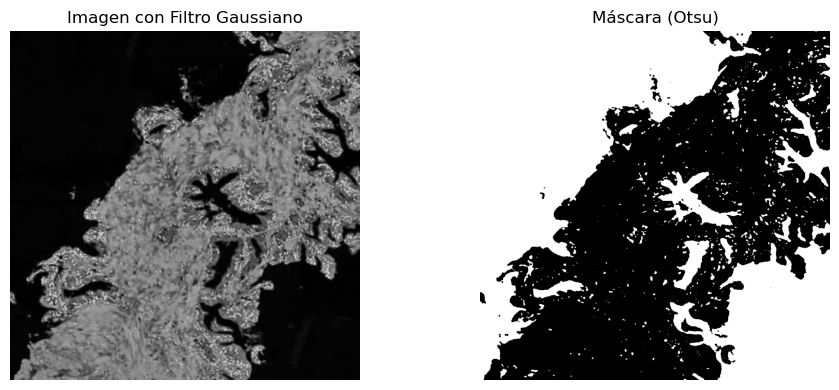

In [6]:
# Aplicar filtro gaussiano de tamaño 5x5
img_gaus = cv2.GaussianBlur(M, (5, 5), 0)

# Aplicar umbral de Otsu (la salida es una imagen binaria)
_, mask_otsu = cv2.threshold(img_gaus, 0, 1, cv2.THRESH_OTSU)
mask_otsu = 1-mask_otsu
print(np.unique(mask_otsu))

# Visualizar imagen suavizada
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_gaus, cmap='gray')
plt.title('Imagen con Filtro Gaussiano')
plt.axis('off')

# Visualizar máscara resultante
plt.subplot(1, 2, 2)
plt.imshow(mask_otsu, cmap='gray')
plt.title('Máscara (Otsu)')
plt.axis('off')

plt.tight_layout()
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [8]:
from skimage import morphology

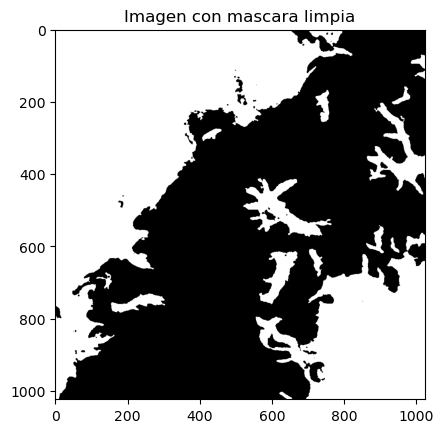

In [9]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
mask_binaria = mask_otsu > 0
mask_limpia = morphology.remove_small_objects(mask_binaria, min_size=301)
plt.imshow(mask_limpia, cmap='gray')
plt.title('Imagen con mascara limpia')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [10]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 



In [11]:
from skimage import measure

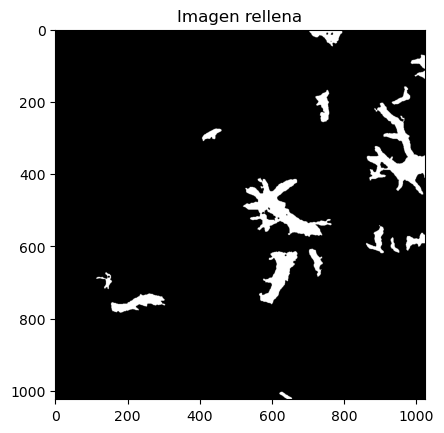

In [13]:
# Convertir la máscara limpia a uint8 (valores 0 y 255)
mask_img = (mask_limpia.astype(np.uint8)) * 255

h, w = mask_img.shape
ref = np.zeros((h+2, w+2), np.uint8)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
cv2.floodFill(mask_img, ref, (0,0), 0); # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
cv2.floodFill(mask_img, ref, (1000,1000), 0);
plt.imshow(mask_img, cmap='gray')
plt.title('Imagen rellena')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

In [15]:
from scipy.ndimage import binary_fill_holes

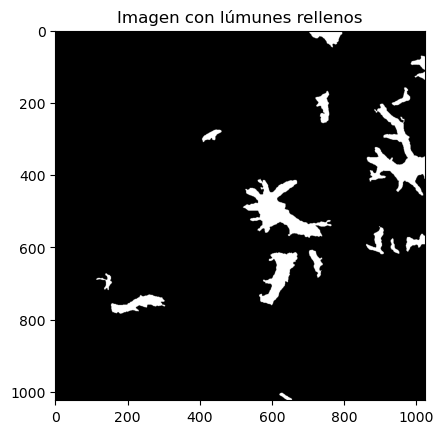

In [16]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

mask_bool = mask_img.astype(bool)

# Rellenar los huecos (por ejemplo, dentro de los lúmenes)
mask_rellena = binary_fill_holes(mask_bool)
plt.imshow(mask_rellena, cmap='gray')
plt.title('Imagen con lúmunes rellenos')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

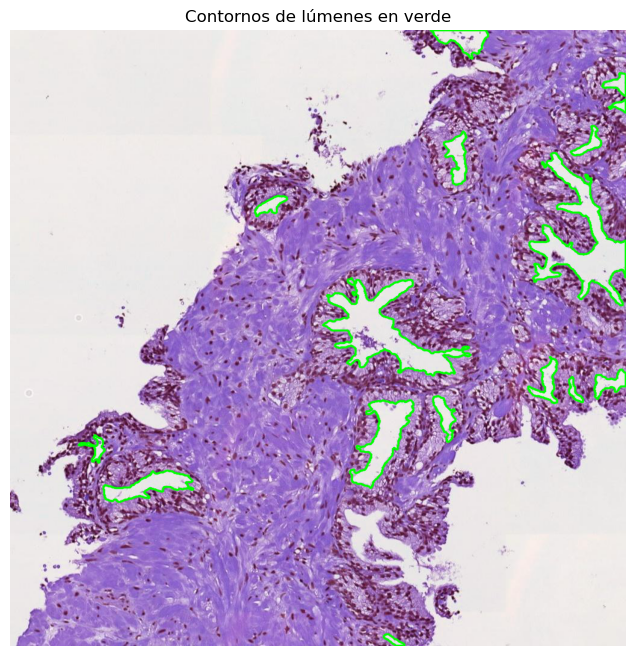

In [17]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

mask_final = (mask_rellena.astype(np.uint8)) * 255

# Encontrar contornos en la máscara
contours, _ = cv2.findContours(mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una copia de la imagen original para dibujar encima
img_contorno = img.copy()

# Dibujar los contornos en verde (BGR: (0, 255, 0))
cv2.drawContours(img_contorno, contours, -1, (0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

# Visualizar la imagen con contornos
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_contorno, cv2.COLOR_BGR2RGB))  # Convertir BGR a RGB para matplotlib
plt.title('Contornos de lúmenes en verde')
plt.axis('off')
plt.show()

#### 7) Identificar y cropear el lumen más grande

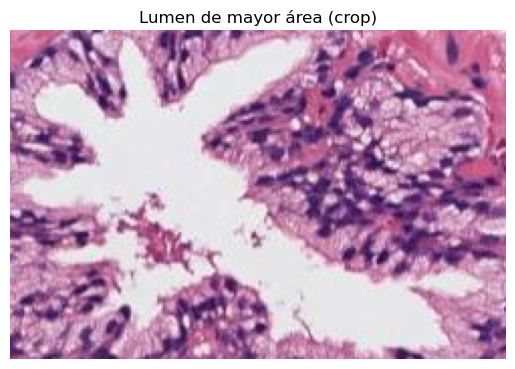

In [18]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

labels = measure.label(mask_rellena)

# Paso 2: Obtener propiedades de las regiones
props = measure.regionprops(labels)

# Paso 3: Encontrar el lumen con mayor área
mayor_lumen = max(props, key=lambda x: x.area)

# Paso 4: Obtener la bounding box (min_row, min_col, max_row, max_col)
minr, minc, maxr, maxc = mayor_lumen.bbox

# Paso 5: Hacer crop sobre la imagen original RGB
crop = img[minr:maxr, minc:maxc, :]

# Visualizar el lumen cropeado
plt.imshow(crop)
plt.title('Lumen de mayor área (crop)')
plt.axis('off')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [19]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad


In [21]:
from tabulate import tabulate
import math
from skimage.measure import regionprops
from scipy.spatial.distance import pdist


crop_mascara = mask_final[minr:maxr, minc:maxc]

prop = regionprops(crop_mascara.astype(np.uint8))
prop = prop[0]

coords = prop.coords
feret = np.max(pdist(coords)) if len(coords) > 1 else 0

# Área y perímetro para compacidad
area = prop.area
perimetro = prop.perimeter
compacidad = np.round(4*math.pi*prop.area/prop.perimeter**2, 4) #(perimetro ** 2) / (4 * math.pi * area) if area > 0 else 0

# Diccionario de características
sol = {
    "Área": round(area, 4),
    "Área de bounding box": round(prop.bbox_area, 4),
    "Área convexa": round(prop.convex_area, 4),
    "Excentricidad": round(prop.eccentricity, 4),
    "Diámetro equivalente": round(prop.equivalent_diameter, 4),
    "Extensión": round(prop.extent, 4),
    "Diámetro Feret": round(feret, 4),
    "Eje mayor": round(prop.major_axis_length, 4),
    "Eje menor": round(prop.minor_axis_length, 4),
    "Orientación": round(prop.orientation, 4),
    "Perímetro": round(perimetro, 4),
    "Solidez": round(prop.solidity, 4),
    "Compacidad": round(compacidad, 4)
}

# Mostrar resultados en tabla
tabla = [(k, v) for k, v in sol.items()]
print(tabulate(tabla, headers=["Característica", "Valor"]))

Característica             Valor
--------------------  ----------
Área                  14075
Área de bounding box  40098
Área convexa          29283
Excentricidad             0.8478
Diámetro equivalente    133.869
Extensión                 0.351
Diámetro Feret          258.155
Eje mayor               238.636
Eje menor               126.549
Orientación               1.0058
Perímetro              1242.6
Solidez                   0.4807
Compacidad                0.1146


In [22]:
import pandas as pd

In [24]:
df = pd.DataFrame(tabla, columns=["Característica", "Valor"])

In [26]:
df.to_excel("imagen1.xlsx")